In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# read data
df = pd.read_excel('data/data_manufacturing.xlsx')

In [5]:
# Get the names of the columns with categorial variables (object data type)
string_col_names = df.dtypes.index[df.dtypes == 'object']

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define the column transformer using a one hot encoder for the columns to transform (string_col_names)
ct = ColumnTransformer(
    transformers=[("encoder", OneHotEncoder(drop="first"), string_col_names)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [7]:
# Perform the transforamtion on the features
data_transformed = ct.fit_transform(df)
# Show the resulting column names
print(ct.get_feature_names_out())

['API Particle Size_Medium' 'API Particle Size_Small'
 'MgSt Supplier_Smith Ind' 'Lactose Supplier_James Ind'
 'Sugar Supplier_Sweet' 'Talc Supplier_Smooth' 'Compressor_COMPRESS2'
 'Coating Supplier_Down' 'Coating Supplier_Mac' 'Mill Time' 'Screen Size'
 'Blend Time' 'Blend Speed' 'Force' 'Coating Viscosity' 'Inlet Temp'
 'Exhaust Temp' 'Spray Rate' 'Atom. Pressure' 'Dissolution']


In [8]:
df = pd.DataFrame(data_transformed, columns=ct.get_feature_names_out())

In [9]:
# Separate features (first columns) from target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [10]:
from sklearn.model_selection import train_test_split
# Randomly split the data set in 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234) #4245

In [11]:
from sklearn.preprocessing import StandardScaler
# define scaler object
sc = StandardScaler()
# fit scaler based on training data, scale training data
X_train_sc = sc.fit_transform(X_train)
# scale test data
X_test_sc = sc.transform(X_test)

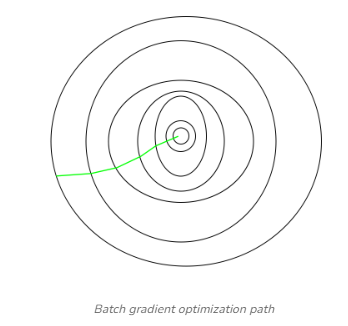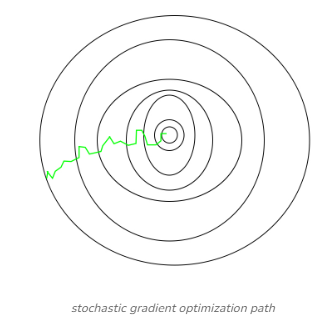

In [21]:
# perform support vector regression for the training data with hyperparameter tuning using a k-fold cross-validation
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from multiprocessing import cpu_count
from scipy.stats import loguniform

# define regressor
regressor = MLPRegressor(early_stopping=True, solver="lbfgs", max_iter=10000)

# hyperparameter definition
tuned_parameters = {
    "hidden_layer_sizes": [5, 10, 15, 20],
    # "batch_size": [8, 16, 32, 64, 128],
    "alpha": loguniform(1e-5, 10),
    "activation": ["tanh", "relu"],
}

# create cross validation object  --> scoring is MSE
tuner = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=tuned_parameters,
    n_iter=50,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=cpu_count() - 2,
    return_train_score=True,
    verbose=2,
)

tuner.fit(X_train_sc, y_train)

print(f"best_params: {tuner.best_params_}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
best_params: {'activation': 'relu', 'alpha': 0.5007456022735376, 'hidden_layer_sizes': 15}


In [22]:
from sklearn.metrics import root_mean_squared_error

# training and testing prediction
y_pred_train = tuner.best_estimator_.predict(X_train_sc)
y_pred_test = tuner.best_estimator_.predict(X_test_sc)

print(f'Train MSE: {root_mean_squared_error(y_pred_train, y_train)}')
print(f'Test MSE: {root_mean_squared_error(y_pred_test, y_test)}')

Train MSE: 0.054378258509077175
Test MSE: 0.8353440183358495


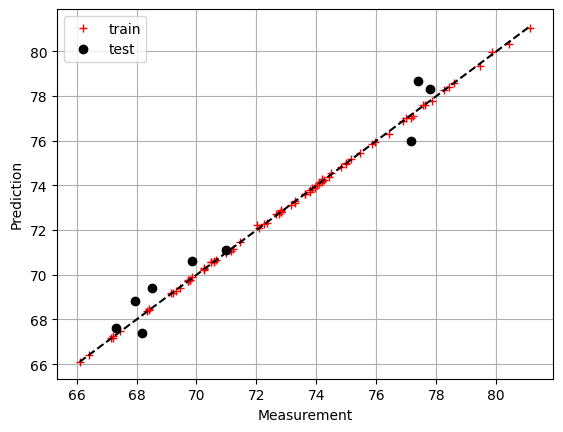

In [23]:
# Parity plot of training and testing data
plt.plot(y_train, y_pred_train, '+r', label='train')
plt.plot(y_test, y_pred_test, 'ko', label='test')
plt.plot([np.min(y_train), np.max(y_train)], [np.min(y_train), np.max(y_train)], 'k--')
plt.grid()
plt.xlabel('Measurement')
plt.ylabel('Prediction')
plt.legend()

### MLP in Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Create sequential model
model = Sequential()

# Add first hidden layer
model.add(
    Dense(
        units=10,
        activation="relu",
        kernel_regularizer=l2(1.78),
        input_shape=(np.shape(X_train)[1],),
    )
)

# Add output layer --> one output
model.add(Dense(units=1))

# compile with solver adam and loss MSE
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# create callback object for early stopping
callback = EarlyStopping(monitor="loss", patience=300, min_delta=1e-6, verbose=0)

# call fit function
history = model.fit(X_train_sc, y_train, epochs=1000, batch_size=16, callbacks=callback)

In [ ]:
# plot loss curve of last fitting step
plt.plot(history.history["loss"])